WHAT IS A DISTRIBUTED SYSTEM?

-> A distributed system is a collection of large number of autonomous computers connected by a communication network which operate in a unified way yo accomplish better performance and throughput. One important feature of a distributed system is transparency which hides the availability of multiple resources of different type from the users of the system. Potential power of a distributed system comes from the way it manages its resources. Management of processing resources(processors or CPUs) is done by two policies of the system: *processor allocation* and *processor scheduling*

-> In distributed systems users initiate processes(tasks or jobs) on different nodes(processors or machines). Due to the variation of speed of processors and the statistical fluctuation of arrival rate of jobs at different nodes, some of the nodes may get overloaded, executing large number of processes while some other node is sitting idle and doing nothing so productive work. This load imbalance between nodes may result in poor performance of the system, there is a need for distributing the system load among all the available processors, called *load distribution*

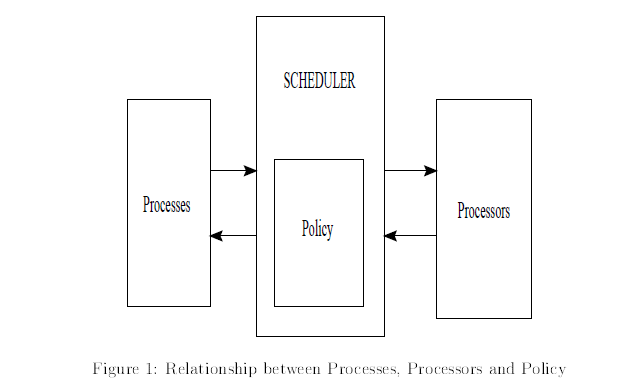

In a distributed system, the responsibility of assigning processors to processes(or the other way around) is accomplished by two components: *Allocator* and *Scheduler*. Each node in distributed system contains its own scheduler to execute processes on the local processor, usually in some timeshared way, whereas the higher level decisions of assigning a task to a node is carried out by a processor allocation algoritm.  

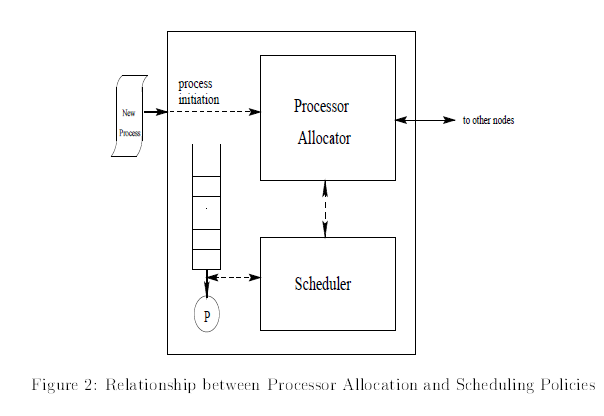

**Random Scheduling:**
The random algorithm relies on uniform probability distribution for task assignment. It is assumed that all nodes are identical in capacity, and task execution times are similar.

When a new task arrives, the scheduler randomly selects a node(server/worker) from the available pool of nodes in the distributed system. This algorithm does not consider the current load on nodes, processing capabilities of nodes or previous task assignments. So a heavily loaded node may receive more tasks which leads to inefficiency.

Implementation Steps:
1. Define the Nodes, Tasks and Load Tracker.
2. Assign the tasks randomly
  - For each task assign the task to a randomly selected node from the list and update the load tracker.
3. Display the results.

In [1]:
import random
import numpy as np

NUM_PROCESSORS = 10
ITERATION = 1000
PROCESS_ARRIVAL_RATE = 0.3
MAX_LOAD_PER_PROCESS = 10
T_MAX = 90
T_MIN = 30
K = 3

In [2]:
def random_scheduling():
  loads = [0] * NUM_PROCESSORS
  for _ in range(ITERATION):
    if random.random() < PROCESS_ARRIVAL_RATE:
      p = random.randint(0, NUM_PROCESSORS - 1)
      load = random.randint(1, MAX_LOAD_PER_PROCESS)
      loads[p] += load
  return {
      'loads': loads,
      'requests' : 0,
      'migrations': 0
  }

**Maximum Threshold Algorithm:**
When a process arrices, it is first tentatively assigned to a processor. If that processor is overloaded(its load exceeds a defined threshold), it tries to offload (migrate) the process to another processor whose load is below the threshold. On non-availability of a suitable node within the probe limit, the originating node must execute the task.

Implementation Steps:
1. Define the Nodes, Thresholds and Load Tracker.
2. Initialize the system state which means creating:
  - A list of processors with their current CPU loads initialized to zero.

  - Counters to track:

      - Total number of processes created.

      - Number of requests sent to check other processors' loads.

      - Number of successful migrations.
3. Simulate the each step: If a process arrives, assigned it a random CPU load between 1 and max_laod_per_process. Then select a random processor to tentatively assign the process to, and calculate the what the load would be if the process were assigned there.
4. If the tentative processor's load does not exceed threshold then:
  - Assign the process to that processor.
Otherwise:
  - The processor tries to offload the process to a better one.

5. Attempt to Migrate the Process:
- For each contacted processor:
  - Check if its current load + processor is below the threshold. If you find such a processor -> assign the process to it and stop searching.
  - If none of the contacted processors is suitable -> Assign the process to the original overloaded processor anyway

In [9]:
def maximum_threshold_algorithm():
  loads = [0] * NUM_PROCESSORS
  requests = 0
  migrations = 0
  for _ in range(ITERATION):
    if random.random() < PROCESS_ARRIVAL_RATE:
      p = random.randint(0, NUM_PROCESSORS - 1)
      load = random.randint(1, MAX_LOAD_PER_PROCESS)
      if loads[p] + load <= T_MAX:
        loads[p] += load
      else:
        requests += 1
        candidates = random.sample([i for i in range(NUM_PROCESSORS) if i != p], K)
        migrated = False
        for c in candidates:
          requests += 1
          if loads[c] + load <= T_MAX:
            loads[c] += load
            migrations += 1
            migrated = True
            break
        if not migrated:
          loads[p] += load

  return {
      'loads': loads,
      'requests': requests,
      'migrations': migrations
  }

**Minimum Threshold Algorithm(Receiver-Initiated Load Balancing):**
This strategy is proactive from the perspective of underloaded processors. Unlike the Maximum Threshold, where overloaded processors try to push their load away, here underloaded processors try to pull work in when they're underutilized.
- A load level below a minimum threshold is considered underloaded.
- When a processor becomes underloaded, it sends requests to other processors to check if they have any process to migrate.
- It tries to pull work from busy processors(those with load above som high threshold or with pending tasks).

Implementation Steps:
1. Define the simulation parameters like number of processors in the system, T_min, T_max, and number of processors to contact when trying to pull a process.
2. Initialize the system state:
  - A list/array to track the CPU load for each processor, initially all zero.
3.
  * First when processes arrive, assign it to a random processor and keep track of the CPU load of each processor.
  * Then check for the underloaded processors.
  * Attempt to pull a process
    - For underloaded processor P, randomly choose k other processors and for each of them check if their load is greater than T_max or it has a queue of processes. After a suitable donor is found pull the process and stop searching. If no donor is found the processor P remains underloaded for now.


In [11]:
def minimum_threshold_algorithm():
  loads = [0] * NUM_PROCESSORS
  requests = 0
  migrations = 0
  for _ in range(ITERATION):
    if random.random() < PROCESS_ARRIVAL_RATE:
      p = random.randint(0, NUM_PROCESSORS - 1)
      load = random.randint(1, MAX_LOAD_PER_PROCESS)
      loads[p] += load
    for p in range(NUM_PROCESSORS):
      if loads[p] < T_MIN:
        candidates = random.sample([i for i in range(NUM_PROCESSORS) if i != p], K)
        for c in candidates:
          requests += 1
          if loads[c] > T_MAX:
            migrated_load = min(MAX_LOAD_PER_PROCESS, loads[c])
            loads[c] -= migrated_load
            loads[p] += migrated_load
            migrations += 1
            break
  return {
      'loads': loads,
      'requests': requests,
      'migrations': migrations
  }

In [25]:
if __name__ == "__main__":
  results = {
      'random': random_scheduling(),
      'maximum_threshold': maximum_threshold_algorithm(),
      'minimum_threshold': minimum_threshold_algorithm()
  }

  for algo, data in results.items():
    print(f"\nAlgorithm: {algo.upper()}")
    print(f"Max Load: {max(data['loads'])}")
    print(f"Std Dev Load: {np.std(data['loads']):.2f}")
    print(f"Requests Sent: {data['requests']}")
    print(f"Migrations: {data['migrations']}")


Algorithm: RANDOM
Max Load: 196
Std Dev Load: 21.57
Requests Sent: 0
Migrations: 0

Algorithm: MAXIMUM_THRESHOLD
Max Load: 220
Std Dev Load: 25.06
Requests Sent: 663
Migrations: 22

Algorithm: MINIMUM_THRESHOLD
Max Load: 221
Std Dev Load: 36.11
Requests Sent: 6159
Migrations: 2


Comparing the results:

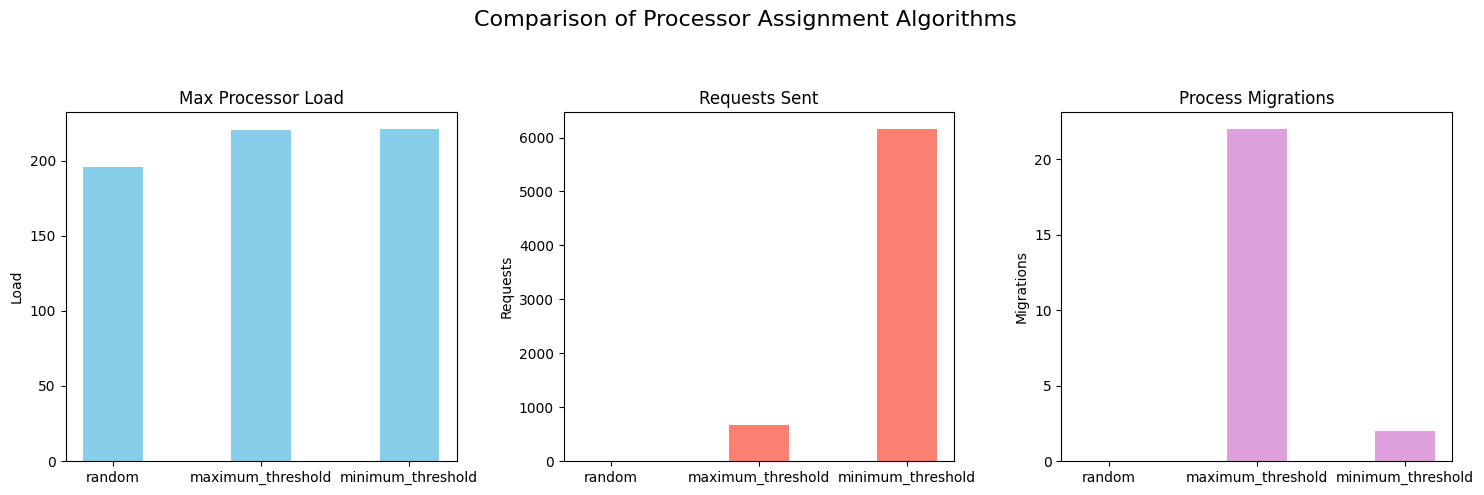

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting Function
def plot_results(results):
    algos = list(results.keys())
    max_loads = [max(results[algo]['loads']) for algo in algos]
    requests = [results[algo]['requests'] for algo in algos]
    migrations = [results[algo]['migrations'] for algo in algos]

    x = np.arange(len(algos))
    width = 0.4

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Comparison of Processor Assignment Algorithms", fontsize=16)

    axs[0].bar(x, max_loads, color='skyblue', width=width)
    axs[0].set_title("Max Processor Load")
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(algos)
    axs[0].set_ylabel("Load")

    axs[1].bar(x, requests, color='salmon', width=width)
    axs[1].set_title("Requests Sent")
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(algos)
    axs[1].set_ylabel("Requests")

    axs[2].bar(x, migrations, color='plum', width=width)
    axs[2].set_title("Process Migrations")
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(algos)
    axs[2].set_ylabel("Migrations")

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

plot_results(results)